In [1]:
import numpy as np

from scipy.io import loadmat
from scipy.io import savemat

from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

import os

from mpl_toolkits.basemap import Basemap

In [2]:
#files on disk, with file names to save to
herc_file = 'HDGridE_x53_nmo_cropped_bandpassed.mat'
herc_out_file = 'HDGridE_x53_nmo_cropped_bandpassed_mod.mat'

gps_in_file = 'HD_precisionGPS_2018_Day3.mat'
gps_out_file = 'HD_precisionGPS_2018_Day3_mod.mat'

#load herc dome data, cropped and bandpassed
herc = loadmat(herc_file)

#load precision gps data
prec_gps = loadmat(gps_in_file)
prec_gps['decday'] = prec_gps['gpsdata'][:, 13]

### Inpsect the data

In [3]:
print(herc.keys())

dict_keys(['__header__', '__version__', '__globals__', 'chan', 'data', 'decday', 'dist', 'dt', 'elev', 'lat', 'long', 'pressure', 'snum', 'tnum', 'trace_int', 'trace_num', 'travel_time', 'trig', 'trig_level', 'nmo_depth', 'picks', 'flags'])


In [4]:
print(prec_gps.keys())

dict_keys(['__header__', '__version__', '__globals__', 'elev', 'gpsdata', 'lat', 'long', 'x', 'y', 'decday'])


In [5]:
#print(prec_gps['gpsdata'][:, 13])
print(prec_gps['decday'])

[29.01945602 29.0194676  29.01947917 ... 29.18770834 29.18771991
 29.18773148]


In [6]:
print(herc['decday'][:5])
#look at orginal variable here;
#so we need to somehow combine the ordinal and the 14th column of prec_gps['gpsdata']

[[737454.11485596 737454.11488421 737454.11491231 ... 737454.12296025
  737454.12298836 737454.12301646]]


In [7]:
print(herc['decday'][-5:])

[[737454.11485596 737454.11488421 737454.11491231 ... 737454.12296025
  737454.12298836 737454.12301646]]


### First, let's fix the precision gps's decday variable to correct for the Matlab offset.

In [8]:
print(date.toordinal(date(2019, 1, 29)))

737088


In [9]:
print(737454 - 737088)

366


In [10]:
print(date.fromordinal(737454 - 366))

2019-01-29


In [11]:
herc['decday'] -= 366

In [12]:
print(herc['decday'][:5])

[[737088.11485596 737088.11488421 737088.11491231 ... 737088.12296025
  737088.12298836 737088.12301646]]


In [13]:
print('Year:   ', prec_gps['gpsdata'][:, 0])
print('Day:    ', prec_gps['gpsdata'][:, 1])
print('Seconds:', prec_gps['gpsdata'][:, 2][:4])

Year:    [2019. 2019. 2019. ... 2019. 2019. 2019.]
Day:     [29. 29. 29. ... 29. 29. 29.]
Seconds: [1681.000384 1682.000385 1683.000385 1684.000385]


In [14]:
print(np.unique(prec_gps['gpsdata'][:, 1]))

[29.]


At this point, I should subtract 366 from the herc file to get the correct day of 2019-01-29.

From Ben:
    
The GPS file is: Year, Day, Seconds, Latitude, Longitude, Elevation
The remaining columns are unnecessary. Although you could use column 14 which is decimal day of year.

In [15]:
print(prec_gps['decday'])

[29.01945602 29.0194676  29.01947917 ... 29.18770834 29.18771991
 29.18773148]


In [16]:
prec_gps['decday'] -= 29
prec_gps['decday'] += 737088

In [17]:
print(prec_gps['decday'])

[737088.01945602 737088.0194676  737088.01947917 ... 737088.18770834
 737088.18771991 737088.18773148]


### Now let's look at the radar data.

In [18]:
#add x and y coordinates here
#m = Basemap(projection='stere', llcrnrlon=225, llcrnrlat=-41.45, urcrnrlon=42.24, urcrnrlat=-39.23, 
#           lon_0=180, lat_0=-90)

m = Basemap(projection='spstere', lon_0=180, boundinglat=-80)
x, y = m(herc['long'], herc['lat'])

#we are reconverting the long and lat variables because they are
#not using the same projection as we are
#this will not affect the results that we have
px, py = m(prec_gps['long'], prec_gps['lat'])

# #try the same thing in cartopy
# #no source projection for lat/lon: still in 3D space, but maybe try to pass the original geoid=WGS84
# projection = crs.SouthPoleStereo(central_longitude=180)
# x2, y2 = projection.transform_points(crs.WGS84, x, y)

herc['x'] = x
herc['y'] = y
prec_gps['x'] = px
prec_gps['y'] = py

/home/jakidxav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


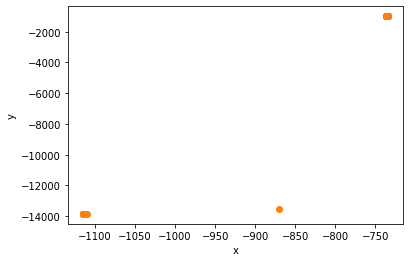

In [19]:
#%matplotlib notebook
plt.scatter(px/1000, py/1000)
plt.scatter(herc['x']/1000, herc['y']/1000)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [20]:
#remove the singleton dimension
herc_lat = np.squeeze(herc['lat'])
herc_lon = np.squeeze(herc['long'])

gps_lat = np.squeeze(prec_gps['lat'])
gps_lon = np.squeeze(prec_gps['long'])

In [21]:
herc_lon += 360

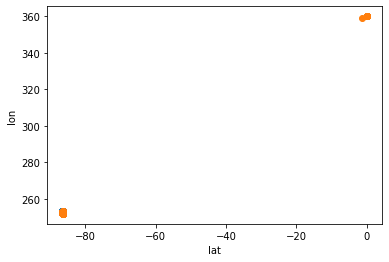

In [22]:
plt.scatter(gps_lat, gps_lon)
plt.scatter(herc_lat, herc_lon)
plt.xlabel('lat')
plt.ylabel('lon')
plt.show()

In [23]:
print(np.where(herc_lon>280)[0])

[ 110  111  112  113  114  115  116  117  118  119  120 1627 1628 1629]


In [24]:
keep_points = np.where(herc_lon<280)[0]
herc_lat = herc_lat[keep_points]
herc_lon = herc_lon[keep_points]

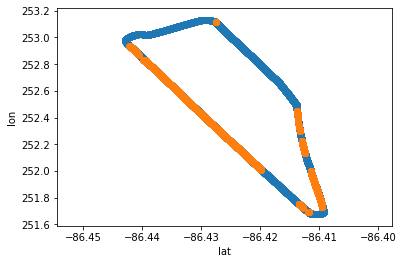

In [25]:
#%matplotlib notebook
plt.scatter(gps_lat, gps_lon)
plt.scatter(herc_lat, herc_lon)
plt.xlabel('lat')
plt.ylabel('lon')
plt.show()

In [26]:
prec_gps['px'] = px
prec_gps['py'] = py

herc['decday'] = herc['decday'][0][keep_points]
#herc['elev'] = herc['elev'][0][keep_points]
#herc['pressure'] = herc['pressure'][0][keep_points]

herc['lat'] = herc_lat
herc['long'] = herc_lon

In [27]:
x2, y2 = m(herc['long'], herc['lat'])

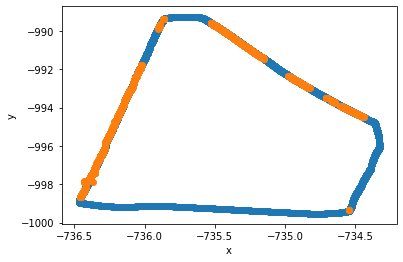

In [28]:
#%matplotlib notebook
plt.scatter(px/1000, py/1000)
plt.scatter(x2/1000, y2/1000)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [29]:
herc['x'] = x2
herc['y'] = y2

In [30]:
savemat('HDGridE_x53_nmo_cropped_bandpassed_mod.mat', herc)
savemat(gps_out_file, prec_gps)

In [32]:
herc.keys()

dict_keys(['__header__', '__version__', '__globals__', 'chan', 'data', 'decday', 'dist', 'dt', 'elev', 'lat', 'long', 'pressure', 'snum', 'tnum', 'trace_int', 'trace_num', 'travel_time', 'trig', 'trig_level', 'nmo_depth', 'picks', 'flags', 'x', 'y'])

In [33]:
prec_gps.keys()

dict_keys(['__header__', '__version__', '__globals__', 'elev', 'gpsdata', 'lat', 'long', 'x', 'y', 'decday', 'px', 'py'])

In [35]:
herc['dist'] = dist = np.hstack(([0], np.cumsum(np.sqrt(np.diff(x) ** 2.0 + np.diff(y) ** 2.0))))